# MIMICScn_hist
- Reads in MIMICS results and checks for change in soil and veg C pool & fluxes
- **Switched to updated CLM5-GSWP3 inputs (created with ctsm_dev110 tag)**
  - Reduced HR biases in mid- and high lats
- Data are here /project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/*/OUTPUT_CN/SPIN

### Notable parameter changes
- Increased MIMICS leaching (function of total DIN pool) 
- Removed density dependent turnover, beta function from Emily's paper
- Introduces flexible microbial C:N, as a function of `fmet` to increase MIC C:N
- Increases FI from inputs to SOMc to increase C:N of total pools 
- MIMICS and CASA simulation in CN mode and C only.
- **`MIMICS_mod5_GSWP3`** + `MIMICS_mod5_Conly`
- `CASACNP_mod4_GSWP3` + `CASACNP_mod4_Conly`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

print('xarray version ' + xr.__version__)
%matplotlib inline

xarray version 0.16.1


In [2]:
#import pandas.util.testing as tm
path  = '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/'
outCN = '/OUTPUT_CN/HIST/'
outC  = '/OUTPUT_C/HIST/'
year  = [1901,2014] # for first and last year of simulations 
# CASA CN
CASsimCN = 'CASACNP_mod4_GSWP3'
pathCAScn = [path+CASsimCN+outCN+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathCAScnANN = path+CASsimCN+outCN+'ann_casaclm_pool_flux_1901_2014.nc' 

# CASA C only
CASsimC = 'CASACNP_mod4_Conly'
pathCASc = [path+CASsimC+outC+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathCAScANN = path+CASsimC+outC+'ann_casaclm_pool_flux_1901_2014.nc' 


# MIMICS CN
MIMsimCN = 'MIMICS_mod5_GSWP3'
pathMIMcn = [path+MIMsimCN+outCN+'mimics_pool_flux_'+str(i)+'_daily.nc' for i in year]  
pathMIMcn2= [path+MIMsimCN+outCN+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
pathMIMcnANN = path+MIMsimCN+outCN+'ann_mimics_pool_flux_1901_2014.nc'  
pathMIMcn2ANN= path+MIMsimCN+outCN+'ann_casaclm_pool_flux_1901_2014.nc'  
# try looking at runs from updated restart files 
#pathMIMcn = [path+MIMsimCN+'/OUTPUT_CN/HIST3/mimics_pool_flux_'+str(i)+'_daily.nc' for i in year]  
#pathMIMcn2= [path+MIMsimCN+'/OUTPUT_CN/HIST3/casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year] 
#pathMIMcnANN = path+MIMsimCN+'/OUTPUT_CN/HIST3/ann_mimics_pool_flux_1901_2014.nc'  
#pathMIMcn2ANN= path+MIMsimCN+'/OUTPUT_CN/HIST3/ann_casaclm_pool_flux_1901_2014.nc'  

print(pathMIMcn)
print(pathMIMcnANN)
print(pathMIMcn2ANN)

# MIMICS C only
MIMsimC  = 'MIMICS_mod5_Conly'
pathMIMc = [path+MIMsimC+outC+'mimics_pool_flux_'+str(i)+'_daily.nc'  for i in year]  
pathMIMc2= [path+MIMsimC+outC+'casaclm_pool_flux_'+str(i)+'_daily.nc' for i in year]   
pathMIMcANN = path+MIMsimC+outC+'ann_mimics_pool_flux_1901_2014.nc'  
pathMIMc2ANN= path+MIMsimC+outC+'ann_casaclm_pool_flux_1901_2014.nc'  

['/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3/OUTPUT_CN/HIST/mimics_pool_flux_1901_daily.nc', '/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3/OUTPUT_CN/HIST/mimics_pool_flux_2014_daily.nc']
/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3/OUTPUT_CN/HIST/ann_mimics_pool_flux_1901_2014.nc
/project/tss/wwieder/biogeochem_testbed_1.1/GRID_CN/MIMICS_mod5_GSWP3/OUTPUT_CN/HIST/ann_casaclm_pool_flux_1901_2014.nc


#### Open datasets and combine MIMICS output into one file

In [3]:
# CASAcn
CAScnANN  = xr.open_mfdataset(pathCAScnANN, decode_times=True, combine='by_coords')

#CASAc only
CAScANN  = xr.open_mfdataset(pathCAScANN, decode_times=True, combine='by_coords')

# MIMICScn
MIMcn1ANN = xr.open_mfdataset(pathMIMcnANN, decode_times=True, combine='by_coords')
MIMcn2ANN = xr.open_mfdataset(pathMIMcn2ANN, decode_times=True, combine='by_coords')
MIMcnANN = xr.combine_by_coords([MIMcn1ANN, MIMcn2ANN], compat='override',
                                data_vars='all',combine_attrs='override')

# MIMICSc only
MIMc1ANN = xr.open_mfdataset(pathMIMcANN, decode_times=True, combine='by_coords')
MIMc2ANN = xr.open_mfdataset(pathMIMc2ANN, decode_times=True, combine='by_coords')
MIMcANN = xr.combine_by_coords([MIMc1ANN, MIMc2ANN], compat='override',
                               data_vars='all',combine_attrs='override')

print('-- read in annual dataset -- ')

-- read in annual dataset -- 


In [4]:
MIMcn1 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMcn]
MIMcn2 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMcn2]
MIMc1 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMc]
MIMc2 = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathMIMc2]
CAScn = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathCAScn]
CASc = [xr.open_mfdataset(p, decode_times=True, combine='by_coords') for p in pathCASc]

yeardim = xr.DataArray(year, dims='year', name='year') # or can use np.arange
yeardim

def reshapeDataset(ds):
    # convert decimal year to day of year
    ds[0]['time'] = np.round(((ds[0]['time'] - 1901)*365), 0)
    ds[1]['time'] = ds[0]['time'] 
    ds = xr.concat(ds, dim=yeardim)
    ds = ds.rename({'time':'DOY'})
    return(ds)
    
MIMcn1 = reshapeDataset(MIMcn1)
MIMcn2 = reshapeDataset(MIMcn2)
MIMc1 = reshapeDataset(MIMc1)
MIMc2 = reshapeDataset(MIMc2)
CAScn = reshapeDataset(CAScn)
CASc = reshapeDataset(CASc)

MIMcn = xr.combine_by_coords([MIMcn1, MIMcn2], compat='override',data_vars='all',combine_attrs='override')
MIMc = xr.combine_by_coords([MIMc1, MIMc2], compat='override',data_vars='all',combine_attrs='override')
print('-- read in daily dataset -- ')

-- read in daily dataset -- 


In [5]:
#MIMcn

#### Sum soil C & N pools

In [6]:
# Single annual cycle:
CAScn = utils.sum_pools(CAScn,'cas',CN='True')
CASc  = utils.sum_pools(CASc, 'cas',CN='False')
MIMcn = utils.sum_pools(MIMcn,'mim',CN='True')
MIMc  = utils.sum_pools(MIMc, 'mim',CN='False')

# Full transient time series (annual mean) 
CAScnANN = utils.sum_pools(CAScnANN,'cas',CN='True')
CAScANN  = utils.sum_pools(CAScANN, 'cas',CN='False')
MIMcnANN = utils.sum_pools(MIMcnANN,'mim',CN='True')
MIMcANN  = utils.sum_pools(MIMcANN, 'mim',CN='False')

Mask out low productivity grids (where NPP<10 gC/m2/y)
- Use mean of first 20 years from MIMICScn run to ensure same mask for all simulations

In [7]:
minNPP = 10/365 # npp given in gC/m2/d
initNPP = MIMcnANN.cnpp.isel(time=slice(0,20)).mean(dim='time')
#print(initNPP)                            
MIMcnANN = MIMcnANN.where(initNPP>minNPP)
CAScnANN = CAScnANN.where(initNPP>minNPP)
CAScANN = CAScANN.where(initNPP>minNPP)
MIMcANN = MIMcANN.where(initNPP>minNPP)

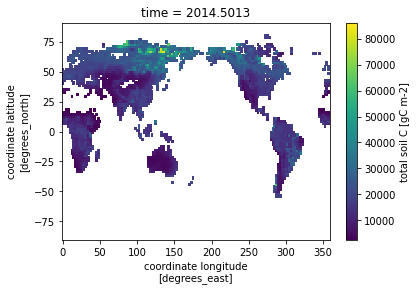

In [14]:
#MIMcnANN.cTOT.isel(time=-1).plot()

Calculate zonal means

In [8]:
zon_meanCNmim = MIMcnANN.mean(dim='lon') 
zon_meanCNcas = CAScnANN.mean(dim='lon')
zon_meanCcas = CAScANN.mean(dim='lon') 
zon_meanCmim = MIMcANN.mean(dim='lon') 

# strings for labeling panels
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']  

# Read observations:
- Microbial C and C:N, Xu et al. 2013  https://doi-org.cuucar.idm.oclc.org/10.1111/geb.12029, avail @ https://doi.org/10.3334/ORNLDAAC/1264
- Soil C:N_GSDE, Shangguan et al. 2014, doi:10.1002/2013MS000293, avail @ http://globalchange.bnu.edu.cn/research/soilwd.jsp, 
- Soil C HWSD and NCSCD
- HR Hashimoto et al Biogeosciences 12: 4121-4132. doi:10.5194/bg-12-4121-2015, downloaded from http://cse.ffpri.affrc.go.jp/shojih/data/index.html

In [9]:
obsIn = "/project/tss/wwieder/soilCN/global_run/"

xuMic = obsIn+'GLOBAL_MICROBIAL_BIOMASS_C_N_P_1264/data/Global_Soil_Microbial_BiomassCN.nc'
dsXu = xr.open_mfdataset(xuMic, decode_times=True,combine='by_coords')
#dsXu.CN100cm.plot(robust=True);

GSDE = obsIn+'GSDE/'
GSDEoc = xr.open_mfdataset(GSDE+'OC5min.nc', decode_times=True,combine='by_coords')
GSDEtn = xr.open_mfdataset(GSDE+'TN5min.nc', decode_times=True,combine='by_coords')
GSDEoc['CN'] = GSDEoc.OC / GSDEtn.TN.where(GSDEtn.TN>0)
GSDEoc['CNmean'] = GSDEoc.CN.where(GSDEoc.depth<=100).mean(dim='depth')
print('max soil C:N '+str(GSDEoc['CNmean'].max().values))
#mask out silly values
GSDEoc['CNmean2'] = GSDEoc['CNmean'].where(GSDEoc['CNmean']<150)

HWSD = obsIn+'input_data/Soil_obs.nc'
dsOBS = xr.open_mfdataset(HWSD, decode_times=True,combine='by_coords')

NCSCD = obsIn+'input_data/NCSCD_Circumarctic_100cmSOCC_025deg.nc'
dsNCSCD = xr.open_mfdataset(NCSCD, decode_times=True,combine='by_coords')

dsHR = xr.open_mfdataset((obsIn+'RH_yr_Hashimoto2015.nc'), decode_times=False,combine='by_coords' )
#dims = time, lev, lat, lon gC/m2/y

dsOBS['HWSD_SOCall'] = dsOBS.HWSD_SOC.sum(dim='nlevsoi').where(dsOBS.HWSD_SOC.isel(nlevsoi=0)>0)
dsOBS['HWSD_SOCall'].attrs = dsOBS.HWSD_SOC.attrs
#dsOBS.HWSD_SOCall.plot();
zon_meanOBS = dsOBS.mean(dim='lon') * 1000 #gC/m2
zon_stdOBS = dsOBS.std(dim='lon') * 1000 #gC/m2
print('')
print('-- read in observed data -- ')
#dsNCSCD.NCSCD_SOC

max soil C:N 5353.0

-- read in observed data -- 


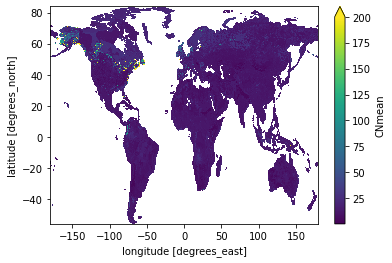

In [10]:
GSDEoc['CNmean'].plot(vmax=200);
#CNtemp = xr.concat([GSDEoc['CNmean'],GSDEoc['CNmean2']],'soilCN')
#print(CNtemp)
#simple = CNtemp.plot(col="soilCN", col_wrap=2,robust=True);

### Plot zonal means for models and observations

/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwieder/.conda/envs/analysis/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/wwiede

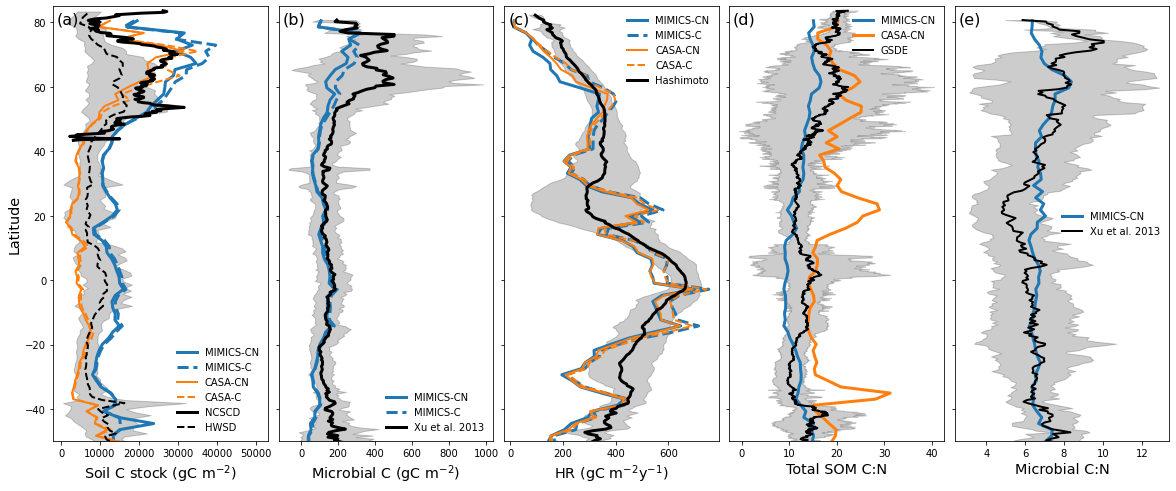

In [11]:
tPlot = 0  #time period to plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True, figsize=[20,8])
# Remove space between axes
fig.subplots_adjust(hspace=0, wspace=0.05)
color = ['tab:blue','tab:orange'] # for MIM, CAS
linestyle= ['-', '--']            # for CN,  Conly

# SOC
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','NCSCD','HWSD']
ax1.plot(zon_meanCNmim.get('cTOT').isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax1.plot(zon_meanCmim.get('cTOT').isel(time=tPlot),  zon_meanCmim.lat, lw=3,color=color[0],linestyle=linestyle[1])
ax1.plot(zon_meanCNcas.get('cTOT').isel(time=tPlot), zon_meanCNcas.lat,lw=2,color=color[1],linestyle=linestyle[0])
ax1.plot(zon_meanCcas.get('cTOT').isel(time=tPlot), zon_meanCcas.lat,  lw=2,color=color[1],linestyle=linestyle[1])
ax1.plot((dsNCSCD.NCSCD_SOC.mean(dim='lon')*1e2), dsNCSCD.lat,lw=3, color='k') #convert kgC to gC/m2
ax1.plot(zon_meanOBS.get('HWSD_SOCall'), zon_meanOBS.lat,lw=2, color='k',linestyle='--')
ax1.fill_betweenx(zon_meanOBS.lat,
                  zon_meanOBS.get('HWSD_SOCall') + zon_stdOBS.get('HWSD_SOCall'), 
                  zon_meanOBS.get('HWSD_SOCall') - zon_stdOBS.get('HWSD_SOCall'),
                  alpha=0.2, color='k')

ax1.set_xlabel('Soil C stock (gC $\mathregular{m^{-2}}$)', fontsize='x-large')
ax1.set_ylabel('Latitude', fontsize='x-large');
ax1.legend(labels=labels, frameon = False, fontsize='medium',loc=4)
ax1.set_ylim(-50, 85)

# MICc
v = 'cMICtot' # 'cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax2.plot(zon_meanCNmim.get(v).isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax2.plot(zon_meanCmim.get(v).isel(time=tPlot), zon_meanCmim.lat,lw=3,color=color[0],linestyle=linestyle[1])
ax2.plot(dsXu.SMC100cm.mean(dim='lon'), dsXu.lat,lw=3, color='k')
ax2.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.SMC100cm.mean(dim='lon') + dsXu.SMC100cm.std(dim='lon'), 
                  dsXu.SMC100cm.mean(dim='lon') - dsXu.SMC100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax2.set_xlabel('Microbial C (gC $\mathregular{m^{-2}}$)', fontsize='x-large');
labels = ['MIMICS-CN','MIMICS-C','Xu et al. 2013']
ax2.legend(labels=labels, frameon = False, fontsize='medium',loc=4)

# HR
labels = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C','Hashimoto']
ax3.plot(zon_meanCNmim.get('cresp').isel(time=tPlot)*365, zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
ax3.plot(zon_meanCmim.get('cresp').isel(time=tPlot)*365,  zon_meanCmim.lat,  lw=3,color=color[0],linestyle=linestyle[1])
ax3.plot(zon_meanCNcas.get('cresp').isel(time=tPlot)*365, zon_meanCNcas.lat, lw=2,color=color[1],linestyle=linestyle[0])
ax3.plot(zon_meanCcas.get('cresp').isel(time=tPlot)*365, zon_meanCcas.lat, lw=2,color=color[1],linestyle=linestyle[1])
#ax3.plot(zon_meanCNmim.get('cnpp').isel(time=tPlot)*365, zon_meanCNmim.lat, lw=2,color='red',linestyle=linestyle[0])
ax3.plot(dsHR.co2.isel(time=-1,lev=0).mean(dim='lon'), dsHR.lat,lw=3, color='k')
ax3.fill_betweenx(dsHR.lat,   #add SD by lat
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') + dsHR.co2.isel(time=-1,lev=0).std(dim='lon'), 
                  dsHR.co2.isel(time=-1,lev=0).mean(dim='lon') - dsHR.co2.isel(time=-1,lev=0).std(dim='lon'),
                  alpha=0.2, color='k')
ax3.set_xlabel('HR (gC $\mathregular{m^{-2 } y^{-1}}$)', fontsize='x-large')
ax3.legend(labels=labels, frameon = False, fontsize='medium',loc=1)

# Soil C:N
labels = ['MIMICS-CN','CASA-CN','GSDE']
v ='cnTOT' #'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax4.plot(zon_meanCNmim.get(v).isel(time=tPlot), zon_meanCNmim.lat,lw=3,color=color[0],linestyle=linestyle[0])
ax4.plot(zon_meanCNcas.get(v).isel(time=tPlot), zon_meanCmim.lat,lw=3,color=color[1],linestyle=linestyle[0])
ax4.plot(GSDEoc['CNmean2'].mean(dim='lon'), GSDEoc.lat,lw=2, color='k')
#ax4.plot(GSDEoc['CNmean'].mean(dim='lon'), GSDEoc.lat,lw=2, color='r')
ax4.fill_betweenx(GSDEoc.lat,   #add SD by lat
                  GSDEoc['CNmean2'].mean(dim='lon') + GSDEoc['CNmean2'].std(dim='lon'), 
                  GSDEoc['CNmean2'].mean(dim='lon') - GSDEoc['CNmean2'].std(dim='lon'),
                  alpha=0.2, color='k')
ax4.set_xlabel('Total SOM C:N', fontsize='x-large');
ax4.legend(labels=labels, frameon = False, fontsize='medium',loc=0)

# MIC C:N
v5 = 'cnMIC' # 'cnLIT',cnTOT' 'nMineral' 'cSOMc' 'MICrK' 'cnMIC' 'relMIC' 'specRESP'
ax5.plot(zon_meanCNmim.get(v5).isel(time=tPlot), zon_meanCNmim.lat, lw=3,color=color[0],linestyle=linestyle[0])
#ax5.plot(zon_meanCNcas.get(v5).isel(time=tPlot), zon_meanCmim.lat,  lw=3,color=color[1],linestyle=linestyle[0])
ax5.plot(dsXu.CN100cm.mean(dim='lon'), dsXu.lat,lw=2, color='k')
ax5.fill_betweenx(dsXu.lat,   #add SD by lat
                  dsXu.CN100cm.mean(dim='lon') + dsXu.CN100cm.std(dim='lon'), 
                  dsXu.CN100cm.mean(dim='lon') - dsXu.CN100cm.std(dim='lon'),
                  alpha=0.2, color='k')
ax5.set_xlabel('Microbial C:N', fontsize='x-large');
labels = ['MIMICS-CN','Xu et al. 2013']
ax5.legend(labels=labels, frameon = False, fontsize='medium',loc=0);

# add panel labels
ax1.annotate(panel[0], xy=(0.07, 0.97), xycoords=ax1.transAxes, ha='center', va='center',fontsize=16)    
ax2.annotate(panel[1], xy=(0.07, 0.97), xycoords=ax2.transAxes, ha='center', va='center',fontsize=16)    
ax3.annotate(panel[2], xy=(0.07, 0.97), xycoords=ax3.transAxes, ha='center', va='center',fontsize=16)    
ax4.annotate(panel[3], xy=(0.07, 0.97), xycoords=ax4.transAxes, ha='center', va='center',fontsize=16)    
ax5.annotate(panel[4], xy=(0.07, 0.97), xycoords=ax5.transAxes, ha='center', va='center',fontsize=16);    

plt.savefig(path+MIMsimCN+'/figs/'+MIMsimCN+'_Fig_1_ZonalSOM.pdf')


**Figure 1.** Zonal mean plots for MIMICS and CASA simulations (blue and orange lines, respectively) 
with coupled CN biogeochemistry and C-only configuration (solid and dashed lines, respectively) and relevent observations.
Panels show NPP, soil C stocks, soil C:N, microbial biomass pools, and microbial C:N ratios.
- add SD of obs?

- Models show good agreement of stocks & fluxes 
- MIMICS-cn shows weak latitudal variation in soil and microbial C:N. CASA captures is because it uses a pft defined soil C:N
- Should we we try and do a better job doing this, with FI~fMET or temperature?
- What's the C:N of chemically protected C

### Look at changes over historical period

In [16]:
def globalSum ( varIn, area=MIMcnANN.landarea *1e6, timeC=1, conversion=1e-15, units=None, pt=False):
    "Global weighted sum of fluxes & states"
    temp = varIn * area 
    temp = temp.sum(dim=('lat','lon')) * conversion * timeC
    if pt==True:
        print(varIn.attrs['long_name']+' '+str(np.round(temp.values,1))+' Pg C')
    return(temp)

d2y = 365
print('MIMICS cn')
globalSum(MIMcnANN['cgpp'].isel(time=0),timeC=d2y, pt=True)
globalSum(MIMcnANN['cnpp'].isel(time=0),timeC=d2y, pt=True)
globalSum(MIMcnANN['cTOT'].isel(time=0), pt=True);
globalSum(MIMcnANN['cTOT'].isel(time=1), pt=True);
globalSum(MIMcnANN['cECO'].isel(time=0), pt=True);
globalSum(MIMcnANN['cresp'].isel(time=0), timeC=d2y, pt=True);
globalSum(MIMcnANN['cresp'].isel(time=1), timeC=d2y, pt=True);
#print(MIMcnANN)

MIMICS cn
gross primary production 105.1 Pg C
net primary production 36.3 Pg C
total soil C 1737.1 Pg C
total soil C 1736.3 Pg C
total ecosystem C 2047.3 Pg C
soil heterotrophic respiration 38.3 Pg C
soil heterotrophic respiration 37.6 Pg C


['NEP']


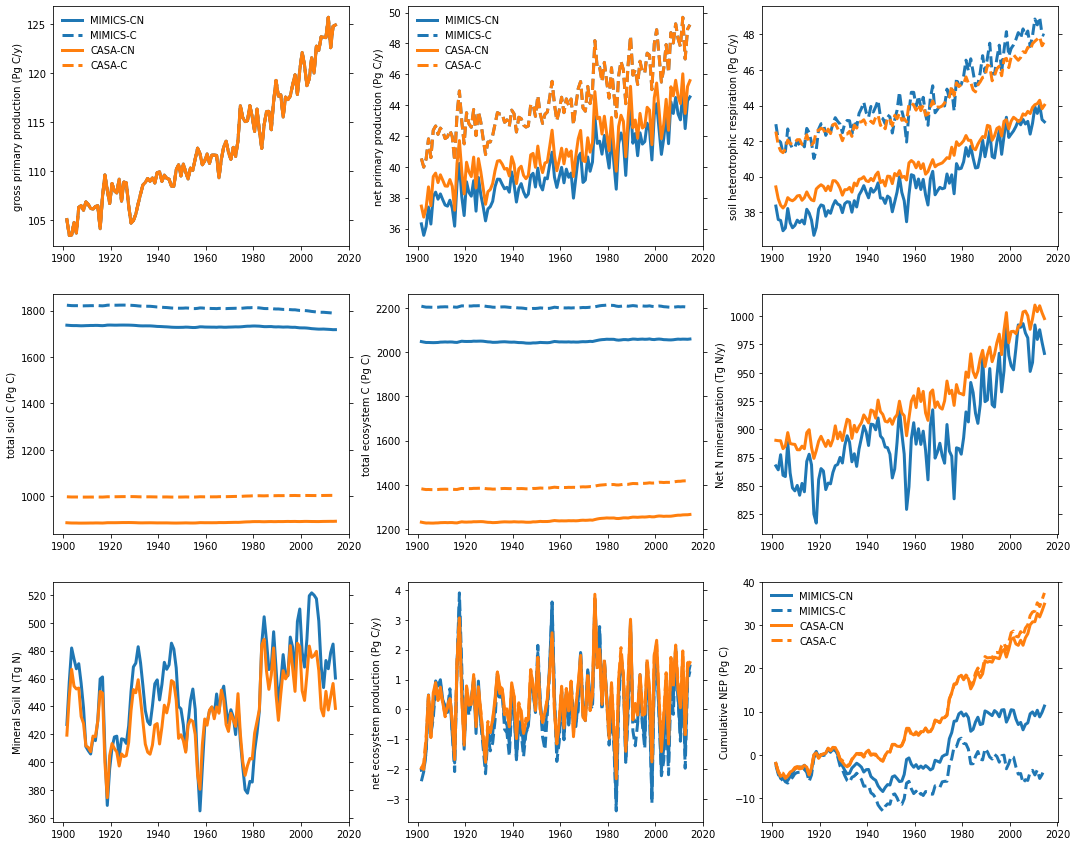

In [17]:
model = ['MIMICS-CN','MIMICS-C','CASA-CN','CASA-C']
var = ['cgpp','cnpp','cresp',
       'cTOT','cECO','nNetMineralization',
       'nMineral','NEP']

nvar  = len(var)
timeC = [365,365,365,1,1,
         365,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15,
              1e-12,1e-12,1e-15]
units = ['(Pg C/y)','(Pg C/y)','(Pg C/y)',
         '(Pg C)','(Pg C)','(Tg N/y)','(Tg N)','(Pg C/y)']

fig = plt.figure(figsize=[18,15])
        
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel(MIMcnANN[var[i]].attrs['long_name']+' '+units[i])
    ax.plot(MIMcnANN.time, globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]), 
             lw=3,color=color[0],linestyle=linestyle[0])
    if (i<=4) | (i>=7): 
        ax.plot(MIMcANN.time, globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion= conversion[i]), 
             lw=3,color=color[0],linestyle=linestyle[1])

    ax.plot(CAScnANN.time, globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]), 
             lw=3,color=color[1],linestyle=linestyle[0])
    if (i<=4) | (i>=7): 
        ax.plot(CAScANN.time, globalSum(CAScANN[var[i]],timeC=timeC[i],conversion= conversion[i]), 
             lw=3,color=color[1],linestyle=linestyle[1])
        
    if i<2:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax = fig.add_subplot(3, 3, 9)
i = 7  
print([var[i]])
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
ax.plot(MIMcnANN.time, np.cumsum(globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[0])
ax.plot(MIMcANN.time, np.cumsum(globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[1])
ax.plot(CAScnANN.time, np.cumsum(globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[0])
ax.plot(CAScANN.time, np.cumsum(globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[1])
ax.legend(labels=model, frameon = False, fontsize='medium');


**Figure X** trends in ecosystem C & N fluxes and pools over the historical period simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Both N models have a higher cumulative NEP, but changes w/ MIMICS-CN are greater.
- Implies longer MRT of soil C pools in CN models, relative to their C-only counterparts 
- **OR** larger increases in NPP from regions experiencing N limitation (relative to the C only model). 
- From change time series below, seems like the biggest differences are in HR (not NPP)

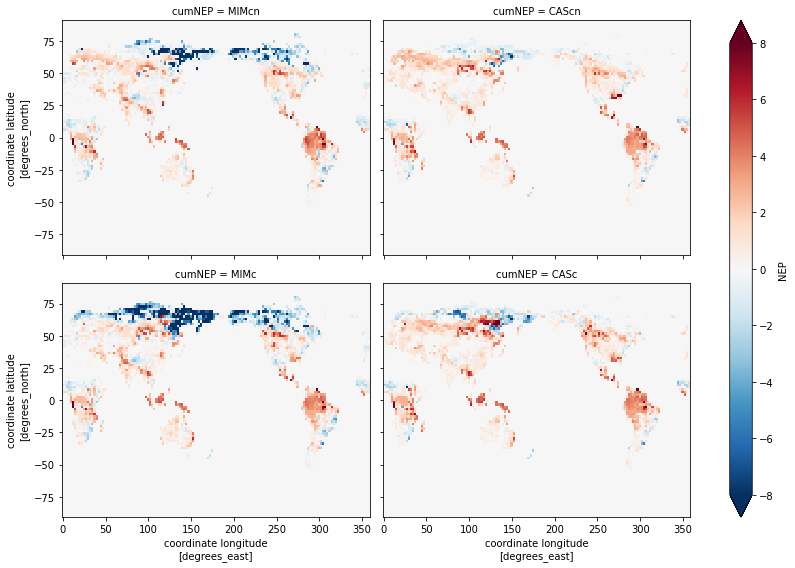

In [18]:
cumMIMcn = MIMcnANN['NEP'].cumsum(dim='time').isel(time=-1)
cumCAScn = CAScnANN['NEP'].cumsum(dim='time').isel(time=-1)
cumMIMc = MIMcANN['NEP'].cumsum(dim='time').isel(time=-1)
cumCASc = CAScANN['NEP'].cumsum(dim='time').isel(time=-1)
cumNEP = xr.concat([cumMIMcn,cumCAScn,cumMIMc,cumCASc], 'cumNEP')
cumNEP['cumNEP'] = ['MIMcn','CAScn','MIMc','CASc']
g_simple = cumNEP.plot(x="lon", y="lat", col="cumNEP", vmax=8, vmin=-8,figsize=[12,8],col_wrap=2,cmap="RdBu_r")


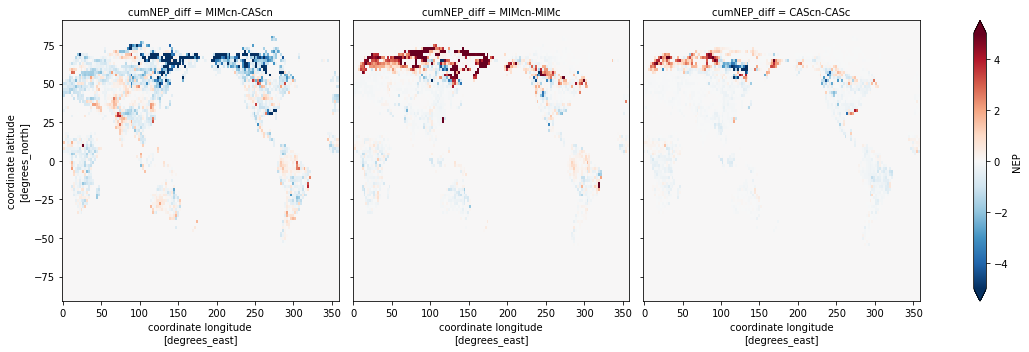

In [19]:
#Differences in NEP CN-Conly
MIMcn_CAScn =(MIMcnANN['NEP'].cumsum(dim='time')-CAScnANN['NEP'].cumsum(dim='time'))
MIMcn_MIMc = (MIMcnANN['NEP'].cumsum(dim='time')-MIMcANN['NEP'].cumsum(dim='time'))
CAScn_CASc =(CAScnANN['NEP'].cumsum(dim='time')-CAScANN['NEP'].cumsum(dim='time'))

cn_c = xr.concat([MIMcn_CAScn,MIMcn_MIMc,CAScn_CASc], 'cumNEP_diff')
cn_c['cumNEP_diff'] = ['MIMcn-CAScn','MIMcn-MIMc','CAScn-CASc']
g_simple = cn_c.isel(time=-1).plot(x="lon", y="lat", col="cumNEP_diff", vmax=5, vmin=-5,col_wrap=3,figsize=[16,5],cmap="RdBu_r")


**Figure y** N effects on cumulative NEP (1901-2014) 
- MIMICS with less net land uptake than CASA (left) 
- Biggest differences in cumulative NEP in MIMICS across arctic and boreal forests (middle), 
- CASA effects of N limitation on cumulative land C uptake are weaker (right) 

Are changes  really just reflecting the degree of initial N limitation in CN models?

['NEP']


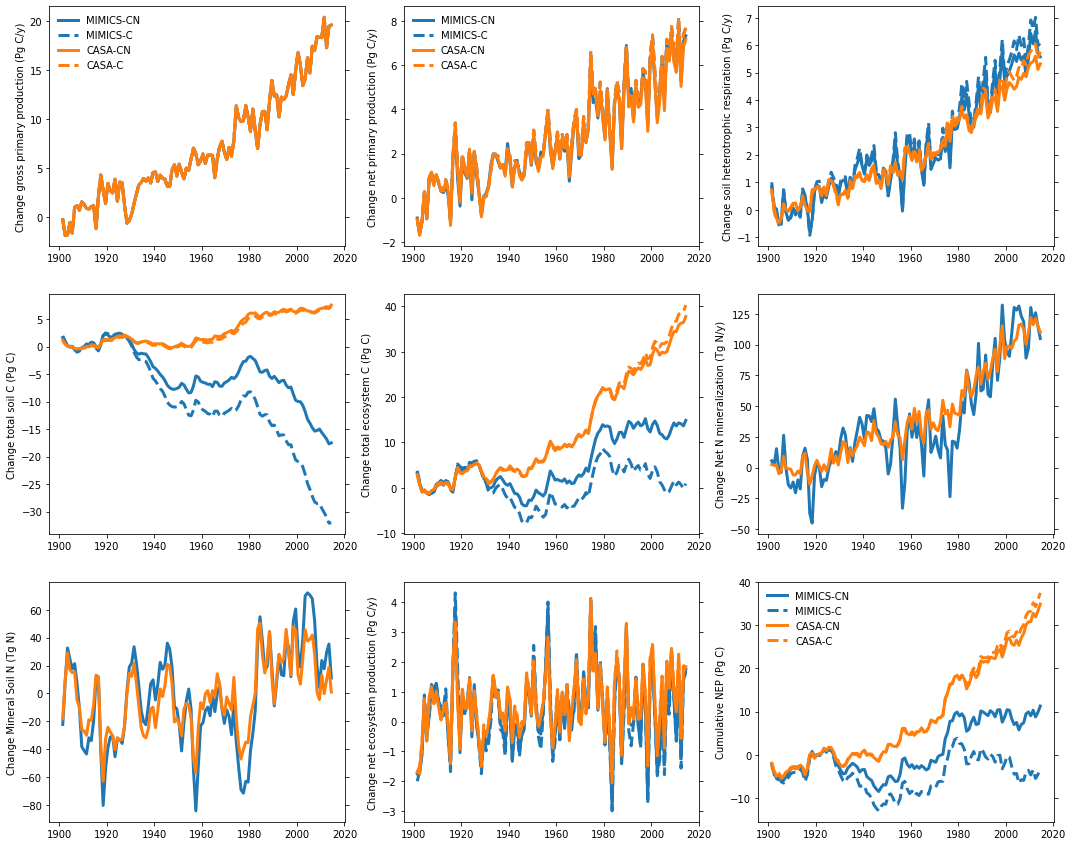

In [20]:
fig = plt.figure(figsize=[18,15]);
t = 10
    
for i in range(nvar):
    ax = fig.add_subplot(3, 3, (i+1))
    ax.yaxis.set_ticks_position('both')
    daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    ax.set_ylabel('Change '+MIMcnANN[var[i]].attrs['long_name']+' '+units[i])
    ax.plot(daMIMcn.time, (daMIMcn-daMIMcn.isel(time=slice(0,t)).mean()),
             lw=3,color=color[0],linestyle=linestyle[0]) 
    if (i<=4) | (i==7): 
        daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
        ax.plot(daMIMc.time, (daMIMc-daMIMc.isel(time=slice(0,t)).mean()), 
                 lw=3,color=color[0],linestyle=linestyle[1]) 

    ax.plot(daCAScn.time,(daCAScn-daCAScn.isel(time=slice(0,t)).mean()), 
             lw=3,color=color[1],linestyle=linestyle[0]) 
    if (i<=4) | (i==7): 
        daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])
        ax.plot(daCASc.time, (daCASc-daCASc.isel(time=slice(0,t)).mean()), 
                 lw=3,color=color[1],linestyle=linestyle[1])         
    if i<2:
        ax.legend(labels=model, frameon = False, fontsize='medium')

ax=fig.add_subplot(3, 3, 9)
i = 7  
print([var[i]])
ax.yaxis.set_ticks_position('both')
ax.set_ylabel('Cumulative '+var[i]+' (Pg C)')
ax.plot(MIMcnANN.time, np.cumsum(globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[0])
ax.plot(MIMcANN.time, np.cumsum(globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[0],linestyle=linestyle[1])
ax.plot(CAScnANN.time, np.cumsum(globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[0])
ax.plot(CAScANN.time, np.cumsum(globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i]).values), 
             lw=3,color=color[1],linestyle=linestyle[1])
ax.legend(labels=model, frameon = False, fontsize='medium');


**Figure X** Changes in ecosystem C & N fluxes and pools, relative to initial conditions, over the historical period 
simulated by MIMICS and CASA (blue and orange lines, respectively), with coupled C-N biogeochemistry and C-only 
configuration (solid and dashed lines, respectively).
- **MIMICS seems to show evidence of priming in second half of simulation, increasing HR and Nmin rates faster than CASA?**
- Does this influence N limitation in regions where SOM turnover is accelerating?
- Greater IAV of C&N fluxes from MIMICS, it would be interesting to see the source & driver of this variability (temp, moisture, productivity).

['cgpp', 'cnpp', 'cresp', 'cTOT', 'cECO', 'nNetMineralization', 'nMineral', 'NEP']


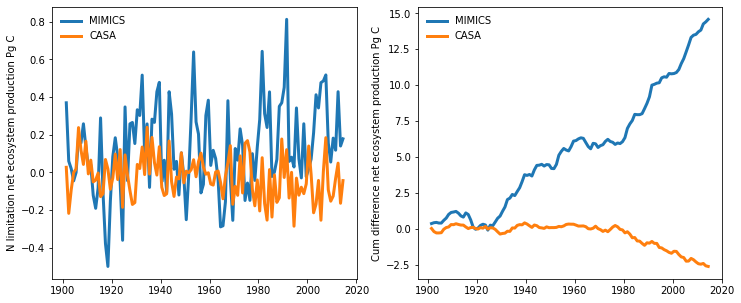

In [21]:
plt.figure(figsize=[12,5]);

i = 7
print(var)
daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])

nlimMIM = daMIMcn - daMIMc
nlimCAS = daCAScn - daCASc

plt.subplot(1, 2, 1)
plt.ylabel('N limitation '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
plt.plot(daMIMcn.time, nlimMIM,lw=3,color=color[0],linestyle=linestyle[0]) 
plt.plot(daCAScn.time, nlimCAS,lw=3,color=color[1],linestyle=linestyle[0])
plt.legend(labels=['MIMICS','CASA'], frameon = False, fontsize='medium')

plt.subplot(1, 2, 2)
plt.ylabel('Cum difference '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
plt.plot(daMIMcn.time, nlimMIM.cumsum(),lw=3,color=color[0],linestyle=linestyle[0]) 
plt.plot(daCAScn.time, nlimCAS.cumsum(),lw=3,color=color[1],linestyle=linestyle[0]); 
plt.legend(labels=['MIMICS','CASA'], frameon = False, fontsize='medium');

**Fig XX** Cumulative N limitation on NPP sum(CN-Conly). Time range of initial values changes results



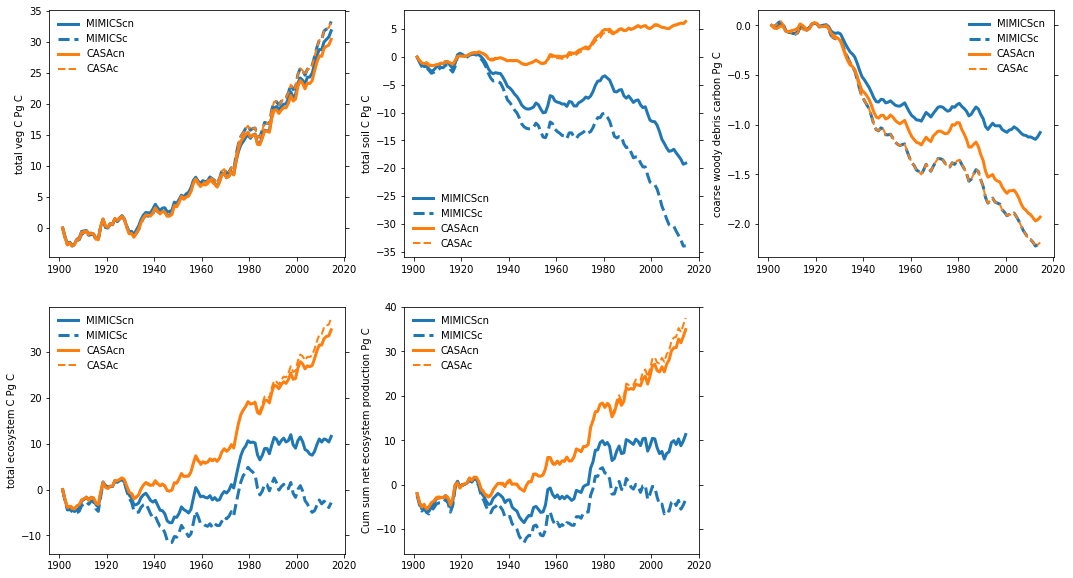

In [22]:
var = ['cVEG','cTOT','clitcwd','cECO','NEP']
timeC = [1,1,1,1,365]
conversion = [1e-15,1e-15,1e-15,1e-15,1e-15]
units = ['(Pg C)','(Pg C)','(Pg C)','(Pg C)','(Pg C/y)']

fig = plt.figure(figsize=[18,10]);

for i in range(len(var)):
    daMIMcn = globalSum(MIMcnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCAScn = globalSum(CAScnANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daMIMc = globalSum(MIMcANN[var[i]],timeC=timeC[i],conversion=conversion[i])
    daCASc = globalSum(CAScANN[var[i]],timeC=timeC[i],conversion=conversion[i])

    ax = fig.add_subplot(2, 3, (i+1))
    if i<4:
        ax.set_ylabel(MIMcnANN[var[i]].attrs['long_name']+' Pg C')
        ax.plot(daMIMcn.time, (daMIMcn-daMIMcn.isel(time=0)),lw=3,color=color[0],linestyle=linestyle[0]) 
        ax.plot(daMIMc.time, (daMIMc-daMIMc.isel(time=0)),lw=3,color=color[0],linestyle=linestyle[1]) 
        ax.plot(daCAScn.time, (daCAScn-daCAScn.isel(time=0)),lw=3,color=color[1],linestyle=linestyle[0])
        ax.plot(daCASc.time, (daCASc-daCASc.isel(time=0)),lw=2,color=color[1],linestyle=linestyle[1])

    else:
        ax.set_ylabel('Cum sum '+MIMcnANN[var[i]].attrs['long_name']+' Pg C')
        ax.plot(daMIMcn.time, (daMIMcn.cumsum()),lw=3,color=color[0],linestyle=linestyle[0]) 
        ax.plot(daMIMc.time, (daMIMc.cumsum()),lw=3,color=color[0],linestyle=linestyle[1]) 
        ax.plot(daCAScn.time, (daCAScn.cumsum()),lw=3,color=color[1],linestyle=linestyle[0])
        ax.plot(daCASc.time, (daCASc.cumsum()),lw=2,color=color[1],linestyle=linestyle[1])
        
    ax.yaxis.set_ticks_position('both')
    plt.legend(labels=['MIMICScn','MIMICSc','CASAcn','CASAc'], frameon = False, fontsize='medium');

### Plot maps of where fluxes are changing

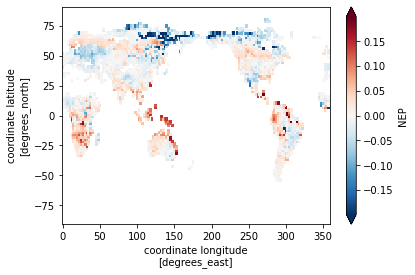

In [23]:
var='NEP'
(MIMcnANN[var].isel(time=slice(-20,None)).mean(dim='time')-
 MIMcnANN[var].isel(time=slice(  0,20  )).mean(dim='time')).plot(robust=True);

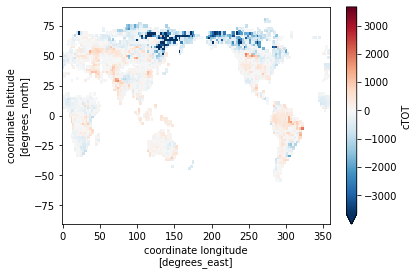

In [24]:
#print(CAScnANN)
var = ['cresp','tsoilC','nNetMineralization','cTOT','fW']
tempMIM = (MIMcnANN[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           MIMcnANN[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempMIM.plot(robust=True);#vmax=0.2,vmin=-0.2,cmap="RdBu_r");

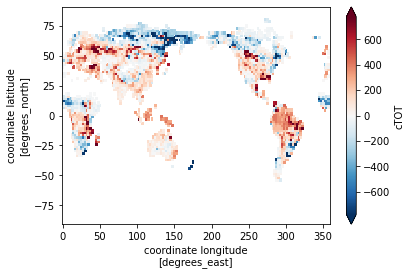

In [25]:
tempCAS = (CAScnANN[var[3]].isel(time=slice(-10,None)).mean(dim='time')-
           CAScnANN[var[3]].isel(time=slice(  0,10  )).mean(dim='time'))
tempCAS.plot(robust=True)#:vmax=0.2,vmin=-0.2,cmap="RdBu_r");

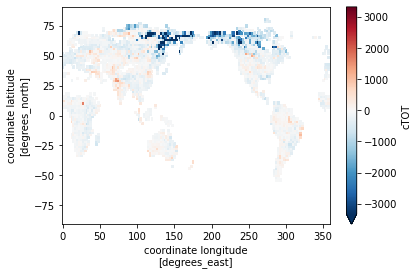

In [26]:
(tempMIM - tempCAS).plot(robust=True);
# not sure what a meaningful way to look at these changes may be?

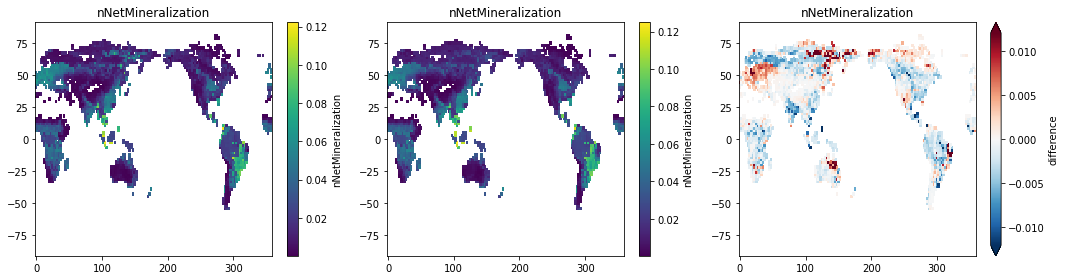

In [27]:
# ratio of respiration:mineralization over time
var = ['cresp','nNetMineralization']
MIMcnANN['HR:Min'] = (MIMcnANN[var[0]]/MIMcnANN[var[1]])
CAScnANN['HR:Min'] = (CAScnANN[var[0]]/CAScnANN[var[1]])
ncols = 3
nrows = 1
#  lists of variables, titles & labels
plotVars = ['nNetMineralization']
plotTitle = ['nNetMineralization']
plotLable = ['nNetMineralization']

# create the plots
fig = plt.figure(figsize=(15,4))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
j=0            
for ax in axes:
    if i == 0:
        MIMcnANN[plotVars[j]].isel(time=-1).plot(ax=ax, cbar_kwargs={'label': plotLable[j]})
    if i == 1:
        CAScnANN[plotVars[j]].isel(time=-1).plot(ax=ax,  cbar_kwargs={'label': plotLable[j]})
    if i == 2:
        (MIMcnANN[plotVars[j]]-CAScnANN[plotVars[j]]).isel(time=-1).plot(ax=ax, robust=True, cbar_kwargs={'label': 'difference'})
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[j])
    i = i+1

plt.tight_layout()

#MIMcnANN['HR:Min'].isel(time=0).plot(robust=True);

In [28]:
#changes in mineralization over time in both models
var2 = ['cnpp','cresp','NEP','cTOT','nNetMineralization','HR:Min','cnTOT']
#var2 = ['cnpp','cresp','NEP','cTOT']
dMIM = MIMcnANN[var2].copy('deep')
dCAS = CAScnANN[var2].copy('deep')
#dCASc = CAScANN[var2].copy('deep')
for i in range(len(var2)):
    dMIM[var[i]] = (MIMcnANN[var[i]]-MIMcnANN[var[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')
    dCAS[var[i]] = (CAScnANN[var[i]]-CAScnANN[var[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')
    #if i<=4:
        # dCASc[var[i]] = (CAScANN[var[i]]-CAScANN[var[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIM,dCAS],dim=model)

#model = xr.DataArray(['MIMICS-cn','CASA-cn','CASA-c'], dims='model', name='model') # or can use np.arange
#t = xr.concat([dMIM,dCAS,dCASc],dim=model)
##t['lat'] = t.lat.where(t.lat> -50)
#t

IndexError: list index out of range

In [ ]:
simple = t[var2[3]].plot(x='time', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);

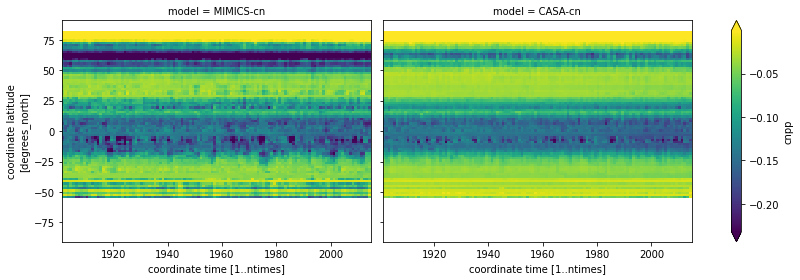

In [30]:
#changes, relative to the C-only model
var2 = ['cnpp','cresp','NEP','cTOT']
dMIM = MIMcnANN[var2].copy('deep')
dCAS = CAScnANN[var2].copy('deep')
#dCASc = CAScANN[var2].copy('deep')
for i in range(len(var2)):
    dMIM[var2[i]] = (MIMcnANN[var2[i]]-MIMcANN[var2[i]]).mean(dim='lon')
    dCAS[var2[i]] = (CAScnANN[var2[i]]-CAScANN[var2[i]]).mean(dim='lon')
    #dMIM[var[i]] = (dMIM[var[i]]-dMIM[var[i]].isel(time=slice(0,20))).mean(dim='lon')
    #dCAS[var[i]] = (dCAS[var[i]]-dCAS[var[i]].isel(time=slice(0,20))).mean(dim='lon')
    #if i<=4:
        # dCASc[var[i]] = (CAScANN[var[i]]-CAScANN[var[i]].isel(time=slice(0,20)).mean(dim='time')).mean(dim='lon')

model = xr.DataArray(['MIMICS-cn','CASA-cn'], dims='model', name='model') # or can use np.arange
t = xr.concat([dMIM,dCAS],dim=model)

#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t[var2[0]].plot(x='time', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);
#model = xr.DataArray(['MIMICS-cn','CASA-cn','CASA-c'], dims='model', name='model') # or can use np.arange
#t = xr.concat([dMIM,dCAS,dCASc],dim=model)
##t['lat'] = t.lat.where(t.lat> -50)
#t

**Figure X.** Zonal mean changes in N mineralization rates simulated by MIMICS-cn & CASA-cn

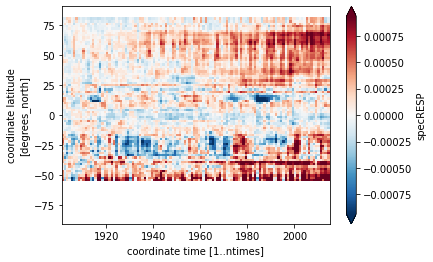

In [31]:
# look a some MIM specific results
var = ['specRESP','cMICtot','MICrK','cnMIC']
(MIMcnANN[var[0]]-MIMcnANN[var[0]].isel(time=slice(0,10)).mean(dim='time')).mean(dim='lon').plot(x='time',y='lat',robust=True);
#MIMcnANN

### Look at environmental controls over soil C:N in MIMICS

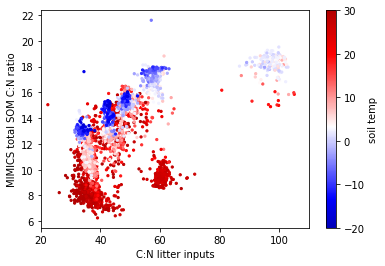

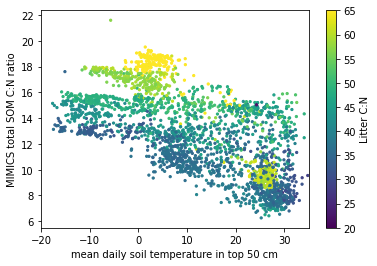

In [32]:
ds_1 = MIMcnANN.isel(time=0)
ds_1['cnLIT'] = (ds_1.cLitInput_metb + ds_1.cLitInput_struc) / (ds_1.nLitInput_metb + ds_1.nLitInput_struc)
ds_1['cnLIT'].attrs['long_name'] = 'C:N litter inputs'

color_by = ds_1.tsoilC
label = 'soil temp'  # Need to rename if 'color_by' is changed

fig, ax = plt.subplots()
s = ax.scatter(ds_1['cnLIT'], ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               cmap = utils.truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = -20,            # Min value
               vmax = 30)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds_1['cnLIT'].attrs['long_name'])
plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
ax.set_xlim(20, 110)
plt.show();

color_by = ds_1['cnLIT'] 
label = 'Litter C:N'     
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6), constrained_layout=True)
fig, ax = plt.subplots()
s = ax.scatter(ds_1.tsoilC, ds_1['cnTOT'],
               c=color_by,
               s=5,
               marker='o',                   # Plot circles
              # alpha = 0.2,
               #cmap = truncate_colormap(cmapIn='seismic', minval=.15, maxval=.9),#plt.cm.seismic, # Color pallete coolwarm
               vmin = 20,            # Min value
               vmax = 65)             # Max value

# Mappable 'maps' the values of s to an array of RGB colors defined by a color palette
cbar = plt.colorbar(mappable = s, ax = ax)   
cbar.set_label(label)
plt.xlabel(ds_1['tsoilC'].attrs['long_name'])
plt.ylabel(ds_1['cnTOT'].attrs['long_name'])
ax.set_xlim(-20, 35)
plt.show();


**Figure X** Litter quality and temperature interact to control soil C:N. 

### Annual cycle of fluxes
This can be done for grid cells, or zonally

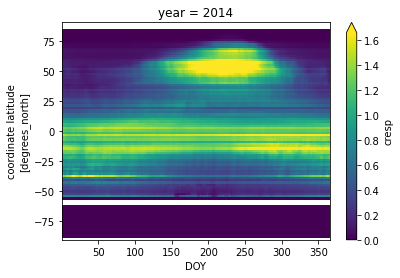

In [33]:
var = ['cMICtot','nMineral','cresp','nNetMineralization','MICrK','cnMIC','cnpp']
v = 2
MIMcn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

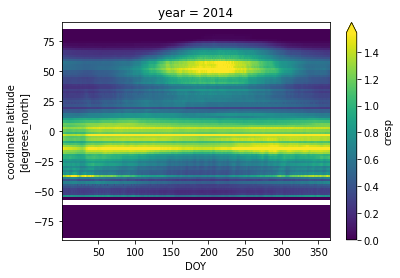

In [34]:
CAScn.isel(year=-1)[var[v]].mean(dim='lon').plot(x='DOY', robust=True);

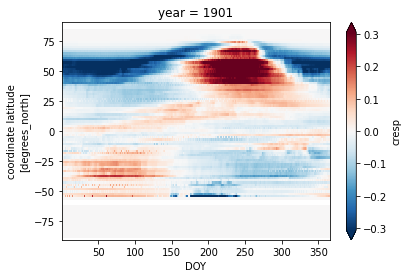

In [35]:
# Differences betweeen models (MIMICS-CASA)
v = 2
(MIMcn.isel(year=0)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(x='DOY', robust=True);

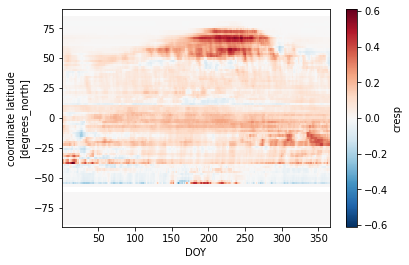

In [36]:
v = 2
(MIMcn.isel(year=1)[var[v]] - MIMcn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2);

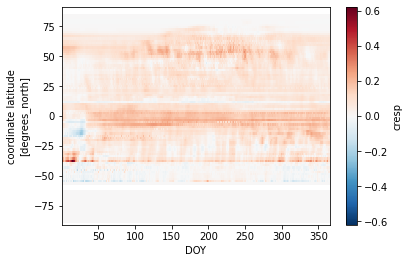

In [37]:
(CAScn.isel(year=1)[var[v]] - CAScn.isel(year=0)[var[v]]).mean(dim='lon').plot(
    x='DOY', cmap='RdBu_r');#, vmax=1e-2,vmin=-1e-2) ;

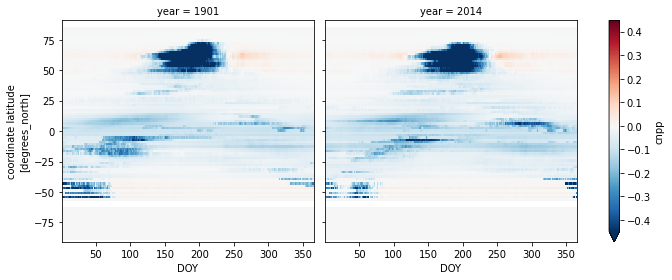

In [38]:
# how N limited are arctic systems at end of simulation in each model?
v = 6
simple = (MIMcn[var[v]]- MIMc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

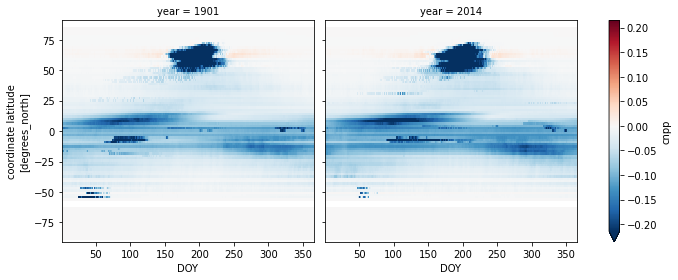

In [39]:
simple = (CAScn[var[v]]- CASc[var[v]]).mean(dim='lon').plot(x='DOY', y='lat',col='year',col_wrap=2, figsize=[10,4],robust=True);#vmax=5e-3,vmin=-5e-3);

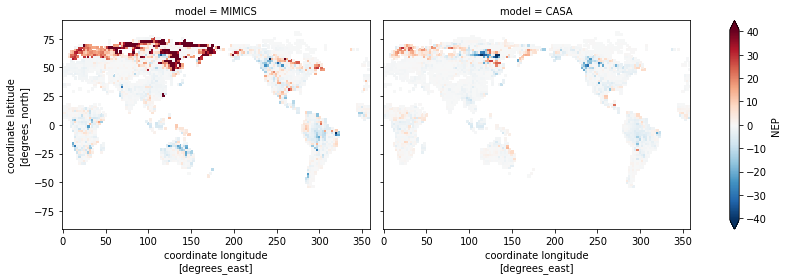

In [40]:
var = 'NEP'
Neff_mim = MIMcnANN[var]-MIMcANN[var]
Neff_cas = CAScnANN[var]-CAScANN[var]
Neff_mim = Neff_mim.isel(time=slice(-20,None)).mean(dim='time') - Neff_mim.isel(time=slice(0,20)).mean(dim='time')
Neff_cas = Neff_cas.isel(time=slice(-20,None)).mean(dim='time') - Neff_cas.isel(time=slice(0,20)).mean(dim='time')
model = xr.DataArray(['MIMICS','CASA'], dims='model', name='model') # or can use np.arange
t = xr.concat([Neff_mim,Neff_cas],dim=model)
t = t*365 #convert from gC/m2/d to gC/m2/y
#t = t-t.isel(time=slice(0,20)).mean(dim='time')
simple = t.plot(x='lon', y='lat',col='model',col_wrap=2, figsize=[12,4],robust=True);#vmax=5e-3,vmin=-5e-3);


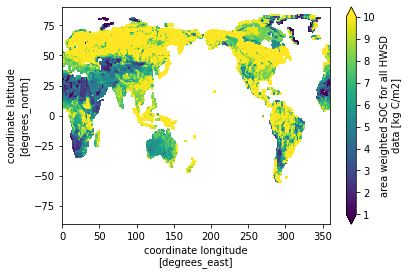

In [41]:
dsOBS['HWSD_SOCall'].plot(vmax=10,vmin=1);